# <center> Projet de Machine Learning: Reconnaissance de marques de voitures </center>


* [**1. Introduction**](#ch1)
  * [1.1 Choix du sujet et objectif du projet](#ch1.1)
  * [1.2 Collecte des données](#ch1.2)
  
* [**2. Modèle de classification binaire**](#ch2)
  * [2.1 Définition du modèle et prédiction](#ch2.1)
  * [2.2 Etude des kernels](#ch2.2)
    * [2.2.1 Méthode "expérimentale"](#ch2.2.1)
    * [2.2.2 Méthode avec "activation map"](#ch2.2.2)
* [**3 Modèle de classification "Softmax"**](#ch3)

* [**4. Conclusion**](#ch3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
import keras.backend as K
from keras import models
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import os
import seaborn as sns

<a id="ch1"></a>

## 1. Introduction

<a id="ch1.1"></a>
### 1.1 Choix du sujet et objectif du projet
Tous deux passionnés de voitures, l'été nous avions eu l'idée de créer un "Shazam des voitures" comme l'application connue permettant de reconnaitre une musique en enregistrant un court morceau. Car en effet, lorsqu'on croise une voiture dans la rue il n'est pas toujours simple de l'identifier. Ce semestre nous avons dû réfléchir à un sujet sur lequel réaliser le projet de machine learning. C'est donc tout naturellement que nous avons décidé de le réaliser sur le thème de la reconnaissance des voitures. Bien sur cela sera une version simplifiée pour être en accord avec nos connaissances aquises depuis janvier en machine learning.  \
L'objectif est que notre algorithme fasse la distinction entre plusieurs marques à partir d'une photographie d'une voiture donnée.

<a id="ch1.2"></a>
### 1.2 Collecte des données





Par manque de données sur internet, nous avons décidé de réaliser nos échantillons nous-mêmes. Pour commencer et pour notre premier modèle, nous avons pris des photos de face dans la rue de véhicules Peugeot et Renault. Nous avons choisi ces marques par soucis de praticité. En effet ce sont les marques les plus communes en France. \\
Nous avons rapidement remarqué que cela était trop chronophage. Nous avons donc étoffé les échantillons en prenant des captures d'écran des voitures en vente sur le site internet *lacentrale.fr*. \\
Pour le deuxième modèle, nous avons gardé les deux marques Peugeot et Renault mais nous avons rajouté une classe "autres" où nous avons mis des photos de diverses marques (BMW, Audi, Mercedes, Citroën et Volkswagen) provenant elles-aussi pour la plupart du site *lacentrale.fr*.\
En tout, on a pu obtenir environ 1600 photos réparties équitablement.
Les photos ont ensuite été modifiées pour être rendues carrées et pour que leur taille soit de 512x512 pixels.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"16M_1d-A77PFOobtTZyZoii0BzoGzILwe"})
#https://drive.google.com/file/d/16M_1d-A77PFOobtTZyZoii0BzoGzILwe/view?usp=sharing
downloaded.GetContentFile('donnees_comp.zip')

**Pour débuter, veuillez importer le fichier donnees_comp.zip dans le même dossier que le notebook.**

In [ ]:
!unzip -q donnees_comp.zip #Parfois il faut l'éxécuter deux fois et entrer "A" la deuxième fois.

In [ ]:
!ls donnees_comp

2marques  3marques  graphs  tests


<a id="ch2"></a>

## 2. Modèle de classification binaire

On importe les modules nécessaires au fonctionnement de notre modèle.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

#import vis
#from keras.applications.vgg16 import VGG16, preprocess_input
#from vis.utils import utils

###2.1 Définition du modèle et prédiction

In [ ]:
image_size = (512, 512)
batch_size = 16

On prend 80% de l'échantillon pour le training et 20% pour la validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "donnees_comp/2marques",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "donnees_comp/2marques",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1043 files belonging to 2 classes.
Using 835 files for training.
Found 1043 files belonging to 2 classes.
Using 208 files for validation.


Ci-dessous, vous pouvez voir des exemples d'images servant à l'entrainement.

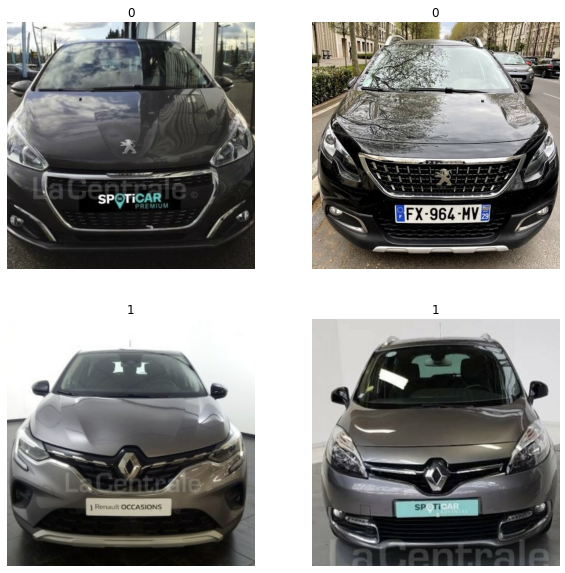

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Pour augmenter la taille de l'échantillon et le diversifier, nous avons réalisé un preprocessing qui induit une rotation aléatoire des images. \
Cela augmente le réalisme car une photo prise par quelqu'un n'est jamais parfaitement droite.

In [ ]:
data_augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomRotation(0.05),
        #layers.experimental.preprocessing.RandomZoom(.5, .2)
        ])

Ci-dessous, vous pouvez voir l'effet du préprocessing sur une image.

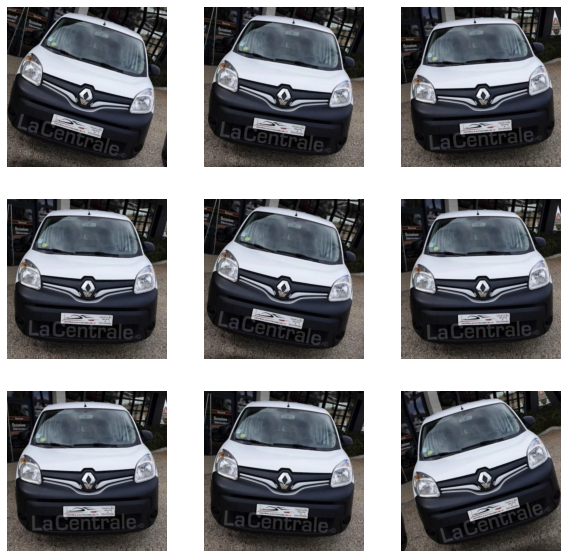

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Nous avons construit un modèle qui est un réseau de neurones. Celui-ci est basé sur un enchainement de convolution et de maxpooling.

In [ ]:
def make_model(input_shape,num_classes):
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  #x = inputs
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)

  x = Conv2D(16,3,padding='same',input_shape=(512,512,3),activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(32,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(64,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(128,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Flatten()(x)
  outputs = Dense(1,activation='sigmoid')(x)
  return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()
weights = model.get_weights()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0     

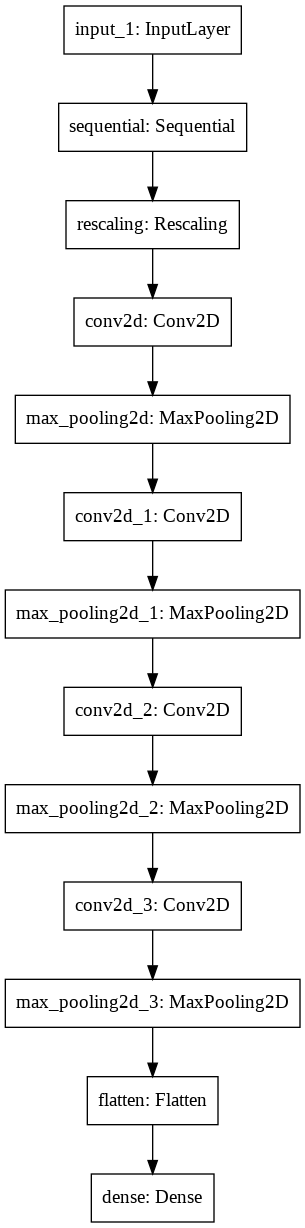

In [ ]:
tf.keras.utils.plot_model(
    model, to_file="model.png", show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

On a remarqué que prendre 30 epochs était satisfaisant. En effet la courbe de la training loss après avoir diminué atteint bien un plateau comme attendu. De plus, la courbe de la validation loss suit celle de la training loss.

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_best.h5",save_best_only=True,),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history=model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/30
53/53 [==============================] - 42s 163ms/step - loss: 0.7520 - accuracy: 0.5657 - val_loss: 0.5440 - val_accuracy: 0.7115
Epoch 2/30
53/53 [==============================] - 8s 145ms/step - loss: 0.5856 - accuracy: 0.7076 - val_loss: 0.5528 - val_accuracy: 0.7115
Epoch 3/30
53/53 [==============================] - 8s 146ms/step - loss: 0.4561 - accuracy: 0.7906 - val_loss: 0.3647 - val_accuracy: 0.8413
Epoch 4/30
53/53 [==============================] - 8s 147ms/step - loss: 0.3049 - accuracy: 0.8697 - val_loss: 0.3212 - val_accuracy: 0.8365
Epoch 5/30
53/53 [==============================] - 8s 146ms/step - loss: 0.2453 - accuracy: 0.9056 - val_loss: 0.2775 - val_accuracy: 0.8750
Epoch 6/30
53/53 [==============================] - 8s 147ms/step - loss: 0.2732 - accuracy: 0.9106 - val_loss: 0.1895 - val_accuracy: 0.9279
Epoch 7/30
53/53 [==============================] - 8s 147ms/step - loss: 0.1545 - accuracy: 0.9408 - val_loss: 0.3009 - val_accuracy: 0.8702
Epoch

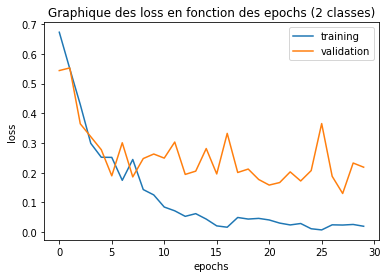

In [ ]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('Graphique des loss en fonction des epochs (2 classes)')
plt.xlabel('epochs'); plt.ylabel('loss'); plt.legend()

Lors de nos premiers essais, nous n'avions pas de preprocessing. Nous n'obtenions pas des courbes satisfaisantes: la validation loss s'éloignait trop de la training loss. Vous trouverez ci-dessous la courbe de la loss de ce modèle:

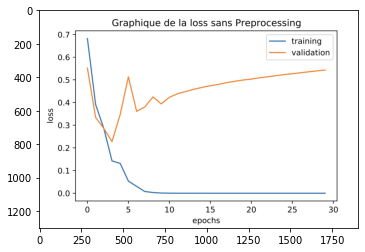

In [ ]:
image2=mpimg.imread("donnees_comp/graphs/sansPreprocessing.png")
plt.imshow(image2)

On extrait la meilleure epoch.

In [ ]:
model.load_weights("save_best.h5")

On définit une fonction permettant de tester le modèle pour une image au choix et qui prédit à quelle marque appartient la voiture sur cette image avec le pourcentage de certitude de l'algorithme.

In [ ]:
def predict2marques(path_image):
  image=mpimg.imread(path_image)
  plt.imshow(image)
  img = keras.preprocessing.image.load_img(
    path_image, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  print(
    "Cette image est à %.2f pourcent peugeot et à %.2f pourcent renault."
    % (100 * (1 - score), 100 * score)
)

Voici un exemple avec une image provenant du dossier *tests*. Vous pouvez essayer avec toute autre image de ce dossier ou d'internet pourvu qu'elle soit prise de face et qu'elle fasse 512x512 pixels.

Cette image est à 4.32 pourcent peugeot et à 95.68 pourcent renault.


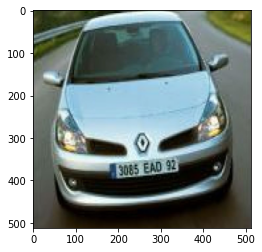

In [ ]:
predict2marques("Test.png")

Les résultats obtenus sont très satisfaisants. Les images de face sont formellement identifiées avec un très bon pourcentage de certitude. L'algorithme est sûr de la marque au minimum à 97%.

###2.2 Etude des kernels

####2.2.1 Méthode "expérimentale"

Comparons les résultats de la prédiction pour une photo sur laquelle on floute différents éléments. Dans un premier temps voici la prédiction sur l'image témoin, donc sans floutage.

Cette image est à 0.00 pourcent peugeot et à 100.00 pourcent renault.


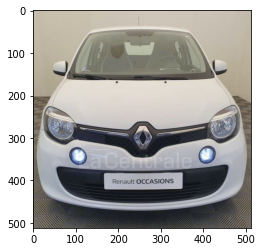

In [ ]:
predict2marques("donnees_comp/tests/twingoavec.jpeg")

Voici le résultat lorsqu'on cache le logo:

Cette image est à 1.93 pourcent peugeot et à 98.07 pourcent renault.


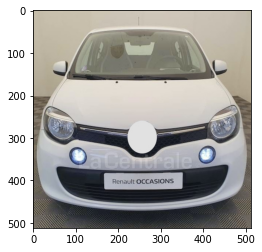

In [ ]:
predict2marques("donnees_comp/tests/twingosanslogo.jpeg")

Voici le résultat lorsqu'on cache les phares:

Cette image est à 0.00 pourcent peugeot et à 100.00 pourcent renault.


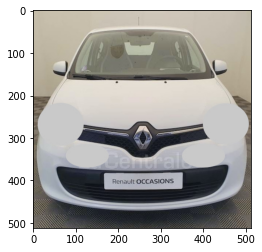

In [ ]:
predict2marques("donnees_comp/tests/twingosansphares.jpeg")

Voici le résultat lorsqu'on cache les phares et le logo:

Cette image est à 67.43 pourcent peugeot et à 32.57 pourcent renault.


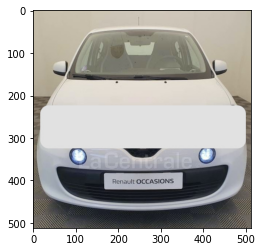

In [ ]:
predict2marques("donnees_comp/tests/twingosansavant.jpeg")

On constate que si on enlève soit le logo soit les phares, la prédiction ne change quasiment pas de l'image témoin. Mais, si on cache à la fois le logo et les phares, l'algorithme se trompe. En effet, une twingo sans logo ni phares renseemble à une Peugeot 108 de part ses proportions.

####2.2.2 Modèle avec "activation map"

On définit les deux fonctions suivantes permettant d'afficher le poids de chaque pixel lors de la dernière couche de convolution.

In [ ]:
def get_output_layer(model, layer_name):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [ ]:
def visualize_class_activation_map(model_path, img_path, output_path):
        model = models.load_model(model_path)
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape
        img = np.array([np.transpose(np.float32(original_img), (0, 1, 2))])
        class_weights = model.layers[-1].get_weights()[0]
        layer_name=model.layers[-3].name
        final_conv_layer = get_output_layer(model, layer_name)
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output,
        model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]
        #Création de l'activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        target_class = 1
        conv_outputs=conv_outputs.reshape(32*32*128,1)
        cam2=conv_outputs*class_weights
        cam2=cam2.reshape(32*32,128)
        cam3=np.sum(cam2,axis=1)
        cam=cam3.reshape(32,32)
        plt.imshow(cam,cmap='viridis')
        plt.title("activation map lors de la dernière couche de convolution")

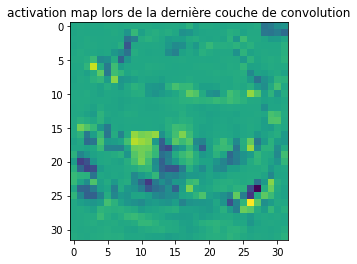

In [ ]:
visualize_class_activation_map('save_best.h5', 'donnees_comp/tests/P108.jpeg', 'donnees_comp')

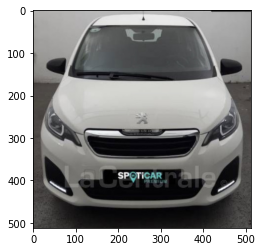

In [ ]:
image=mpimg.imread("donnees_comp/tests/P108.jpeg")
plt.imshow(image)

On remarque que le résultat obtenu suite à cette méthode concorde avec celui obtenu grâce à notre méthode expérimentale. En effet, on voit que l'ensemble formé par la calandre, les feux et le logo est ce sur quoi les kernels se concentrent pour l'identification du véhicule.

##3 Modèle de classification "Softmax"

Dans cette troisième partie on s'interesse à trois classes différentes: Peugeot, Renault et Autres. On change alors de modèle car ce n'est plus un modèle binaire. On utilise alors un système de type Softmax.

In [ ]:
train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    "donnees_comp/3marques",
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    "donnees_comp/3marques",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1615 files belonging to 3 classes.
Using 1292 files for training.
Found 1615 files belonging to 3 classes.
Using 323 files for validation.


In [ ]:
def make_model2(input_shape,num_classes):
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)

  x = Conv2D(16,(3,3),padding='same',input_shape=(500,500,3),activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(32,(3,3),padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(64,(3,3),padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(128,(3,3),padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Flatten()(x)
  outputs = Dense(3,activation='softmax')(x)
  return keras.Model(inputs, outputs)
model2 = make_model2(input_shape=image_size + (3,), num_classes=2)
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 32)      0   

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_best2.h5",save_best_only=True,),
]
model2.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=["accuracy"],
)
history2=model2.fit(
    train_ds2, epochs=epochs, callbacks=callbacks, validation_data=val_ds2,
)

Epoch 1/30
81/81 [==============================] - 23s 266ms/step - loss: 2.1877 - accuracy: 0.3831 - val_loss: 1.1072 - val_accuracy: 0.4830
Epoch 2/30
81/81 [==============================] - 20s 246ms/step - loss: 0.9911 - accuracy: 0.5536 - val_loss: 0.6242 - val_accuracy: 0.7276
Epoch 3/30
81/81 [==============================] - 20s 244ms/step - loss: 0.6611 - accuracy: 0.7401 - val_loss: 0.7207 - val_accuracy: 0.6780
Epoch 4/30
81/81 [==============================] - 20s 246ms/step - loss: 0.4989 - accuracy: 0.7903 - val_loss: 0.3957 - val_accuracy: 0.8359
Epoch 5/30
81/81 [==============================] - 20s 245ms/step - loss: 0.3474 - accuracy: 0.8744 - val_loss: 0.3346 - val_accuracy: 0.8824
Epoch 6/30
81/81 [==============================] - 20s 245ms/step - loss: 0.2869 - accuracy: 0.8801 - val_loss: 0.5698 - val_accuracy: 0.7926
Epoch 7/30
81/81 [==============================] - 20s 245ms/step - loss: 0.2239 - accuracy: 0.9168 - val_loss: 0.3138 - val_accuracy: 0.8824

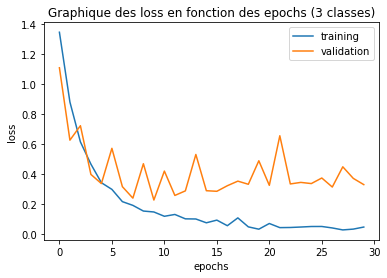

In [ ]:
plt.plot(history2.history['loss'],label='training')
plt.plot(history2.history['val_loss'],label='validation')
plt.title('Graphique des loss en fonction des epochs (3 classes)')
plt.xlabel('epochs'); plt.ylabel('loss'); plt.legend()

In [ ]:
model2.load_weights("save_best2.h5")

On définit maintenant une fonction qui prédit à quelle classe appartient une image:

In [ ]:
def predict3classes(path_image):
  image=mpimg.imread(path_image)
  plt.imshow(image)
  img = keras.preprocessing.image.load_img(
    path_image, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model2.predict(img_array)
  score = predictions[0]
  print(
    "Cette image est à %.2f pourcent autre, à %.2f pourcent Peugeot et à %.2f pourcent Renault."
    % (100 * score[0], 100 * score[1], 100 * score[2])
  )

Cette image est à 100.00 pourcent autre, à 0.00 pourcent Peugeot et à 0.00 pourcent Renault.


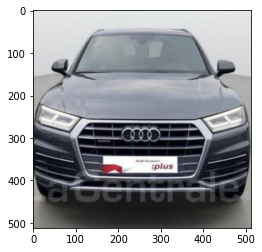

In [ ]:
predict3classes("donnees_comp/tests/autres/audi.jpeg")

Cette image est à 99.32 pourcent autre, à 0.02 pourcent Peugeot et à 0.66 pourcent Renault.


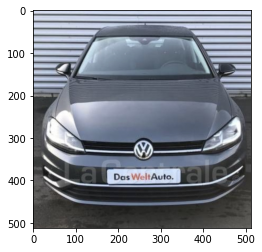

In [ ]:
predict3classes("donnees_comp/tests/autres/volkswagen1.jpeg")

##4 Conclusion
Ce projet nous a permis de découvrir ce qu’était réellement le machine learning. Avant d’entamer cette UE, nous pensions que de tels algorithmes de classification étaient composés d’un enchainement de boucles « if ». La réalité est toute autre comme nous l’avons vu dans ce projet.
Cette UE nous a également donné la possibilité de réaliser un projet que nous avions en tête depuis longtemps et qui nous tenait à coeur, comme nous vous l’avons expliqué dans l’introduction. \\
Avec une modélisation en trois dimensions des véhicules et un bien plus grand échantillon, nous pourrions créer un véritable « shazam des voitures » qui identifierait la marque ainsi que le modèle d’une voiture à partir d’une simple photo.